2. 处理泰坦尼克号数据集，在data/目录里像之前课程里  对读取加州房价数据所做的那样  解压缩此压缩包。

这将提供两个CSV文件，train.csv和test.csv，可以使用pandas.read_csv()加载它。

最后目标：目标是训练一个可以根据其他列预测Survived（是否存活）列的分类器


In [17]:
import numpy as np
import pandas as pd
import tarfile
from pathlib import Path
import os
print(os.getcwd())
def data_read():
    df_path =  Path("datasets/titanic.tgz")
    if not df_path.is_file():
        raise ValueError("数据不存在")
    with tarfile.open(df_path) as f:
        f.extractall(path="datasets")
    return pd.read_csv("datasets/titanic/train.csv"), pd.read_csv("datasets/titanic/test_augmented.csv")
train,test = data_read()

C:\Users\bdqn\PycharmProjects\PythonProject1\ml-test


In [18]:
train.info(),test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

(None, None)

In [99]:
y_train = train.iloc[:,[1]]
X_train = train.iloc[:,2:].drop(["Cabin","Name","Ticket","Embarked"],axis=1)
y_test = test.iloc[:,[1]]
X_test = test.iloc[:,2:].drop(["Cabin","Name","Ticket","Embarked"],axis=1)

In [103]:
X_train .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    object 
 2   Age     714 non-null    float64
 3   SibSp   891 non-null    int64  
 4   Parch   891 non-null    int64  
 5   Fare    891 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 41.9+ KB


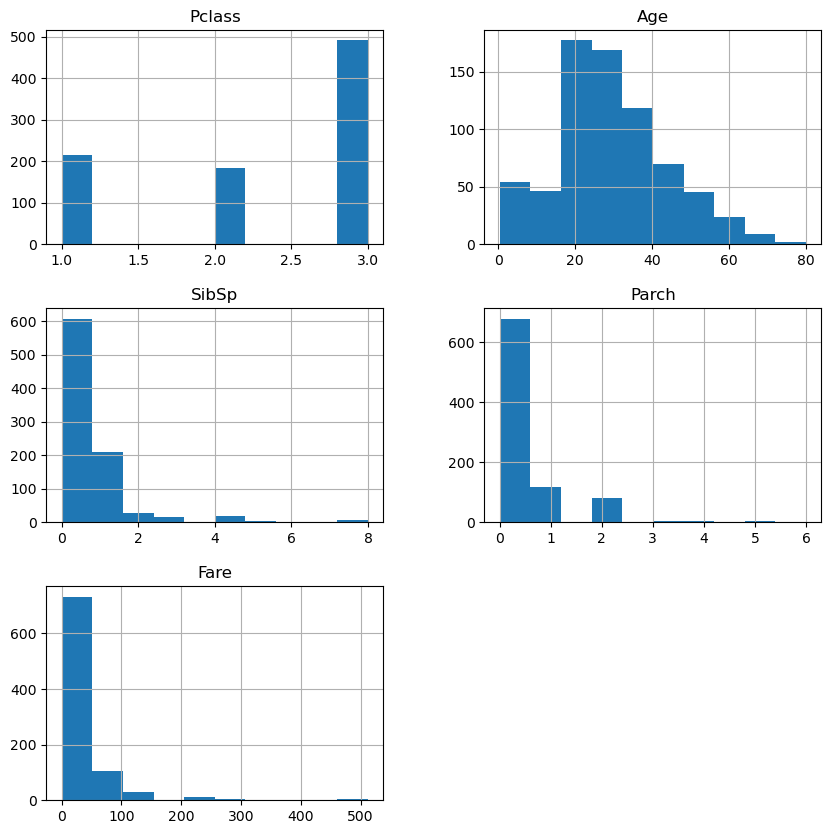

In [124]:
import matplotlib.pyplot as plt
X_train.hist(figsize=(10,10))
plt.show()

In [125]:
from sklearn.preprocessing import FunctionTransformer
# 处理缺失值，不同的数据类型采取不同的处理方法
#
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
X_train_num = X_train.select_dtypes(include=[np.number])[["Age"]]
X_train_num_log = X_train.select_dtypes(include=[np.number])[["SibSp","Parch","Fare"]]
X_train_str = X_train.select_dtypes(exclude=[np.number])

num_pipeline = make_pipeline(SimpleImputer(strategy="median"),StandardScaler())
# 这里需要使用FunctionTransformer将log变成转换器才能用
num_pipeline_log = make_pipeline(SimpleImputer(strategy="median"),FunctionTransformer(np.log1p, validate=True),StandardScaler())
str_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),OneHotEncoder(handle_unknown="ignore"))
ct = ColumnTransformer([
    ("num", num_pipeline, X_train_num.columns),
    ("num_zhongwei",num_pipeline_log,X_train_num_log.columns),
    ("str",str_pipeline, X_train_str.columns)
])

In [126]:
# y_train = y_train.to_numpy().ravel()
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# 定义分类器选项
classifiers = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVC': SVC(random_state=42)
}

# 为每个分类器创建完整管道
pipelines = {}
for name, classifier in classifiers.items():
    pipelines[name] = make_pipeline(ct,classifier)

In [127]:
# 交叉验证评估
# y_test = y_test.to_numpy().ravel()
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring='accuracy')
    print(f"{name}平均准确率: {scores.mean():.4f} (±{scores.std():.4f})")
    scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring='f1_weighted')
    print(f"{name}f1准确率: {scores.mean():.4f}")

RandomForest平均准确率: 0.8781 (±0.0291)
RandomForestf1准确率: 0.8762
LogisticRegression平均准确率: 0.8206 (±0.0251)
LogisticRegressionf1准确率: 0.8040
SVC平均准确率: 0.8541 (±0.0447)
SVCf1准确率: 0.8451
